In [1]:
import pandas as pd

In [21]:
df=pd.read_csv("/content/Fraud_check.csv")

In [22]:
df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [23]:
df.info()
df=df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [24]:
df['Taxable_Income'] = pd.cut(df['Taxable.Income'], bins=[0,30000,float('inf')], labels=['Risky','Good'])
df.drop('Taxable.Income', axis=1, inplace=True)

In [25]:
df['Taxable_Income'].value_counts()

Good     476
Risky    124
Name: Taxable_Income, dtype: int64

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Taxable_Income'] = label_encoder.fit_transform(data['Taxable_Income'])

In [27]:
from sklearn.preprocessing import OneHotEncoder
df_categorical = df[['Undergrad', 'Marital.Status', 'Urban']]

In [28]:
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(df_categorical)
# Convert the result to a DataFrame with column names
df_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(df_categorical.columns))

df = df.drop(['Undergrad', 'Marital.Status', 'Urban'], axis=1)
df = pd.concat([df, df_encoded], axis=1)




In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City.Population          600 non-null    int64  
 1   Work.Experience          600 non-null    int64  
 2   Taxable_Income           600 non-null    int64  
 3   Undergrad_NO             600 non-null    float64
 4   Undergrad_YES            600 non-null    float64
 5   Marital.Status_Divorced  600 non-null    float64
 6   Marital.Status_Married   600 non-null    float64
 7   Marital.Status_Single    600 non-null    float64
 8   Urban_NO                 600 non-null    float64
 9   Urban_YES                600 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 47.0 KB


In [31]:
X = df.drop('Taxable_Income', axis=1)

In [32]:
# Initialize the Isolation Forest model
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)  # You can adjust the contamination parameter
isolation_forest.fit(X)

# Predictions: 1 for inliers (normal observations), -1 for outliers (anomalies)
outlier_predictions = isolation_forest.predict(X)

# Create a new column 'IsOutlier' in the original DataFrame
df['IsOutlier'] = outlier_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [33]:
df['IsOutlier'].value_counts()

 1    570
-1     30
Name: IsOutlier, dtype: int64

In [34]:
# Filter out rows where 'IsOutlier' is -1 (outliers)
df_no_outliers = df[df['IsOutlier'] == 1]
# Drop the 'IsOutlier' column as it's no longer needed
df_no_outliers = df_no_outliers.drop('IsOutlier', axis=1)
print(df_no_outliers)

     City.Population  Work.Experience  Taxable_Income  Undergrad_NO  \
0              50047               10               0           1.0   
1             134075               18               0           0.0   
3             193264               15               0           0.0   
4              27533               28               0           1.0   
5             116382                0               0           1.0   
..               ...              ...             ...           ...   
595            39492                7               0           0.0   
596            55369                2               0           0.0   
597           154058                0               0           1.0   
598           180083               17               0           0.0   
599           158137               16               0           1.0   

     Undergrad_YES  Marital.Status_Divorced  Marital.Status_Married  \
0              0.0                      0.0                     0.0   
1    

In [36]:
# Split the data
from sklearn.model_selection import train_test_split
X1 = df.drop('Taxable_Income', axis=1)
y1 = df['Taxable_Income']
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [38]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


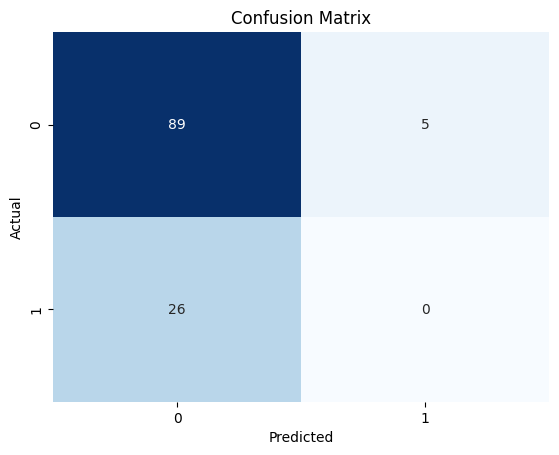

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



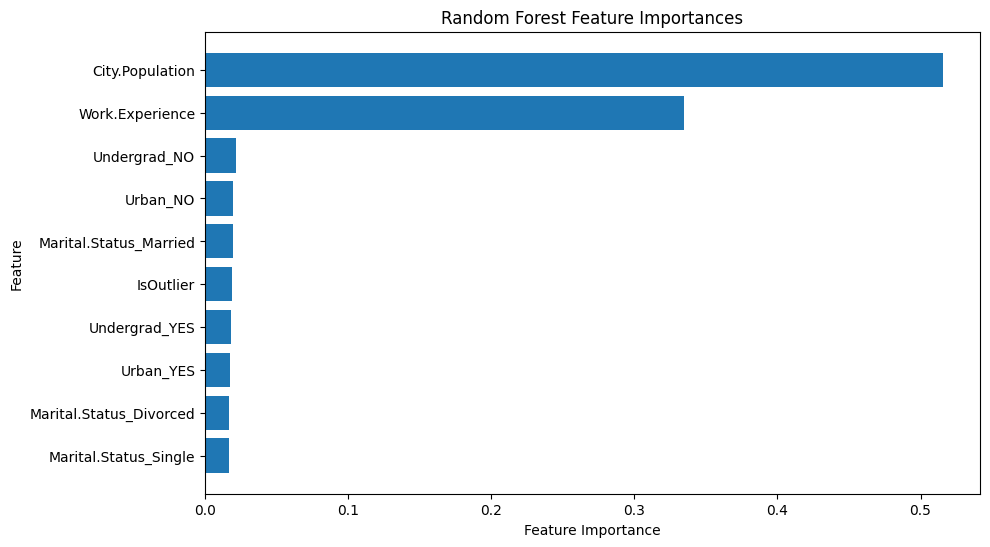

In [40]:
# Feature Importances Plot
feature_importances = random_forest.feature_importances_
feature_names = X_train.columns
indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

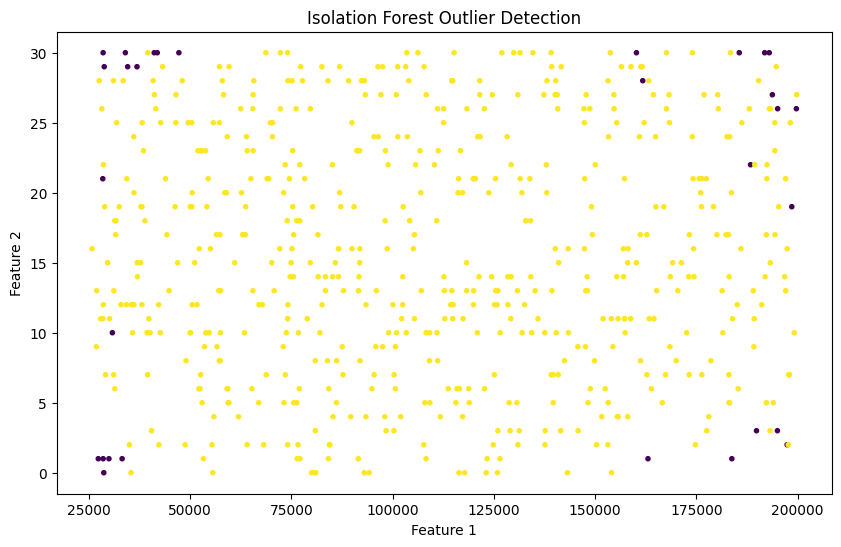

In [41]:
# Outlier Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=df['IsOutlier'], cmap='viridis', marker='.')
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()